## 3 Chamber Sociability test - Behavioural analysis

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, f_oneway

from helper_functions import save_figure
from settings import paths_general, paths_3c_sociability

Load paths

In [2]:
behaviour_data_dir = paths_3c_sociability['behaviour_data_dir']

## Load the animal metadata

First, let's load the metadata that tells us which batch/cage combination is which animal (id).

In [3]:
metadata = pd.read_excel(paths_general['all_animal_metadata'])
metadata

,mouseId,genotype,mouseName,arena,batch,RFID,birthday,weight,sex,species,type,notes
0,78211,DRD2-KO,1.1,1.0,1,4518,2023-04-03,26.6,M,MusMusculus,experimental,NaN
1,78212,DRD2-HET,1.2,1.0,1,4513,2023-04-03,25.6,M,MusMusculus,stimulus,NaN
2,78213,CreWT,1.3,1.0,1,4517,2023-04-03,27.7,M,MusMusculus,stimulus,NaN
3,78210,CreWT,1.4,1.0,1,4521,2023-04-03,26.1,M,MusMusculus,stimulus,NaN
4,78233,DRD2-WT,1.5,2.0,1,4507,2023-04-05,24.6,M,MusMusculus,experimental,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91,39498,CreWT,6.4,NaN,6,4553,2023-08-16,NaN,M,MusMusculus,stimulus,NaN
92,39508,DRD2-WT,6.5,NaN,6,4564,2023-08-15,NaN,M,MusMusculus,experimental,NaN
93,39499,DRD-HET,6.6,NaN,6,4557,2023-08-15,NaN,M,MusMusculus,stimulus,NaN
94,39507,CreWT,6.7,NaN,6,4571,2023-08-16,NaN,M,MusMusculus,stimulus,NaN


As the behaviour was tracked with Boris and saved to a separate file per animal, we load the files separately and merge them into one dataframe.

Note: animal from batch 5 cage 1 does not have an EEG file (transmitter was broken at the time), therefore there is not entry in the metadata file for that animal.

This means we have the following animals:

* batch1:
    * cage1: 78211 - 1.1
    * cage2: 78233 - 1.5
    * cage3: 78227 - 1.9
    * cage4: 78244 - 1.13
* batch2:
    * cage1: 79593 - 2.1
    * cage2: 79592 - 2.5
    * cage3: 79604 - 2.9
    * cage4: 79602 - 2.13
* batch4:
    * cage1: 80620 - 4.1
    * cage2: 80625 - 4.5
    * cage3: 80630 - 4.9
* batch5:
    * cage2: 81175 - 5.5
    * cage3: 81207 - 5.9
    * cage4: 81193 - 5.13
* batch5b:
    * cage1: 81217 - 5.17
    * cage2: 81218 - 5.21
* batch6:
    * cage1: 39489 - 6.1
    * cage2: 39508 - 6.5

With the above information we can create a dictionary that holds the batch-cage combination as keys, and the subject identifiers as values. These can be used to get the genotype that belongs to the individual animals.

In [4]:
subject_id_dict = {
    'batch1_cage1': 78211, 'batch2_cage1': 79593, 'batch5_cage1': 81167, 'batch4_cage1': 80620, 'batch5b_cage1': 81217, 'batch6_cage1': 39489,
    'batch1_cage2': 78233, 'batch2_cage2': 79592, 'batch5_cage2': 81175, 'batch4_cage2': 80625, 'batch5b_cage2': 81218, 'batch6_cage2': 39508,
    'batch1_cage3': 78227, 'batch2_cage3': 79604, 'batch5_cage3': 81207, 'batch4_cage3': 80630,
    'batch1_cage4': 78244, 'batch2_cage4': 79602, 'batch5_cage4': 81193,
}

## Data pre-processing

The data that is exported from the BORIS tracking application provides two rows per state-event. One represents the start of the event, and one the stop, each having a single timestamp.

We want to merge these rows and immediately calculate the duration of the (non)social cup state-event interaction. Let's do this first.

To do so, we define a function that merges some information from the START and the STOP rows.

In [5]:
def merge_event_rows(beh_data):
    merged_df = pd.concat([
        beh_data.iloc[::2].reset_index(drop=True),  # only keep each start row
        beh_data.iloc[::2].reset_index(drop=True)['Image index'].rename('Frame start'),  # interaction start frame, name it 'Frame start'
        beh_data.iloc[1::2].reset_index(drop=True)['Image index'].rename('Frame stop'),  # interaction stop frame, name it 'Frame stop'
        beh_data.iloc[1::2].reset_index(drop=True)['Time'] - beh_data.iloc[::2]['Time'].reset_index(drop=True),  # interaction duration
    ], axis=1)
    # rename the last column as it represents the duration of the interaction
    merged_df = merged_df.set_axis([*merged_df.columns[:-1], 'Interaction duration'], axis=1)
    # drop the columns we don't need
    cols_to_drop = ['Image index', 'Time', 'Observation type', 'Source', 'Time offset (s)', 'Subject', 'Comment', 'Image file path', 'Description', 'Behavioral category', 'Behavior type']
    return merged_df.drop(columns=cols_to_drop)

Then, we create one dataframe holding the behavioural data for all animals. Each row is one interaction event.

In [6]:
beh_df = pd.DataFrame()

# for each behaviour file (which holds behaviour data on one animal only)
for file in os.listdir(behaviour_data_dir):
    if not file.endswith('.xlsx') and 'batch' not in file:
        continue
        
    beh_dat = pd.read_excel(os.path.join(behaviour_data_dir, file))
    
    # get the subject id
    batch, cage = beh_dat['Observation id'].iloc[0].split('_')[:2]
    batch_cage = batch + '_' + cage
    subject_id = subject_id_dict[batch_cage]
    genotype = metadata[metadata.mouseId == subject_id]['genotype'].iloc[0]

    social_cup_starts = beh_dat[(beh_dat['Behavior type'] == 'START') & (beh_dat['Behavior'] == 'social_cup')]
    social_cup_stops = beh_dat[(beh_dat['Behavior type'] == 'STOP') & (beh_dat['Behavior'] == 'social_cup')]
    non_social_cup_starts = beh_dat[(beh_dat['Behavior type'] == 'START') & (beh_dat['Behavior'] == 'non-social_cup')]
    non_social_cup_stops = beh_dat[(beh_dat['Behavior type'] == 'STOP') & (beh_dat['Behavior'] == 'non-social_cup')]
    
    if not len(social_cup_starts) == len(social_cup_stops) or not len(non_social_cup_starts) == len(non_social_cup_stops):
        print(f'Number of event STARTs and STOPs do not match, skipping {beh_dat["Observation id"]} (id: {subject_id_dict[beh_dat["Observation id"]]})')
        continue
    
    # merge the start and stop rows and calculate some stuff (interaction duration etc)
    beh_data = merge_event_rows(beh_dat)
    beh_data.insert(1, 'subject_id', subject_id)
    beh_data.insert(2, 'genotype', genotype)
    beh_df = pd.concat([beh_df, beh_data], axis=0)

Let's inspect the dataframe

In [7]:
beh_df.head()

,Observation id,subject_id,genotype,Observation date,Observation duration,Media duration (s),FPS,Behavior,Media file name,Frame start,Frame stop,Interaction duration
0,batch1_cage1,78211,DRD2-KO,2024-04-09 12:12:11.660,591.186,1899.639,29.97,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,38532,38677,4.835
1,batch1_cage1,78211,DRD2-KO,2024-04-09 12:12:11.660,591.186,1899.639,29.97,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,38726,38843,3.901
2,batch1_cage1,78211,DRD2-KO,2024-04-09 12:12:11.660,591.186,1899.639,29.97,social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,38948,39137,6.303
3,batch1_cage1,78211,DRD2-KO,2024-04-09 12:12:11.660,591.186,1899.639,29.97,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,39325,39337,0.400
4,batch1_cage1,78211,DRD2-KO,2024-04-09 12:12:11.660,591.186,1899.639,29.97,non-social_cup,C:/Users/Olle de Jong/Documents/MSc Biology/rp...,39467,39486,0.634


In [8]:
print(f'Subjects/animals present (n={len(np.unique(beh_df["subject_id"]))}):\n{np.unique(beh_df["subject_id"])} ')

Subjects/animals present (n=19):
[39489 39508 78211 78227 78233 78244 79592 79593 79602 79604 80620 80625
 80630 81167 81175 81193 81207 81217 81218] 


## Sociability metric calculations

In [9]:
behaviour_stats = pd.DataFrame()

# for each behaviour file (which holds behaviour data on one animal only)
for subject_id in np.unique(beh_df["subject_id"]):
    
    subject_data = beh_df[beh_df["subject_id"] == subject_id]
    
    mean_interaction_duration = subject_data.groupby('Behavior')['Interaction duration'].mean()
    interaction_ratio = len(subject_data[subject_data['Behavior'] == 'social_cup']) / len(subject_data[subject_data['Behavior'] == 'non-social_cup'])
    total_interaction_duration_per_behavior = subject_data.groupby('Behavior')['Interaction duration'].sum()
    
    # Sociability Index = (Time in social chamber - Time in non-social chamber) / (Time in social chamber + Time in non-social chamber)
    sociability_index = (total_interaction_duration_per_behavior['social_cup'] -  total_interaction_duration_per_behavior['non-social_cup']) /  (total_interaction_duration_per_behavior['social_cup'] + total_interaction_duration_per_behavior['non-social_cup'])
    
    temp = pd.DataFrame({
        'subject_id': subject_id,
        'genotype': subject_data['genotype'].iloc[0],
        'interaction_ratio': interaction_ratio,
        'total_interaction_time': np.sum(total_interaction_duration_per_behavior.values),
        'total_social_interaction_duration': total_interaction_duration_per_behavior['social_cup'],
        'total_non_social_interaction_duration': total_interaction_duration_per_behavior['non-social_cup'],
        'average_social_cup_duration': mean_interaction_duration['social_cup'],
        'average_non_social_cup_duration': mean_interaction_duration['non-social_cup'],
        'sociability_index': sociability_index,
    }, index=[0])
    behaviour_stats = pd.concat([behaviour_stats, temp], ignore_index=True)

Let's inspect these metrics a bit

In [10]:
behaviour_stats.head()

,subject_id,genotype,interaction_ratio,total_interaction_time,total_social_interaction_duration,total_non_social_interaction_duration,average_social_cup_duration,average_non_social_cup_duration,sociability_index
0,39489,DRD2-KO,1.071429,281.073,160.630,120.443,5.354333,4.301536,0.142977
1,39508,DRD2-WT,0.500000,170.470,40.451,130.019,2.889357,4.643536,-0.525418
2,78211,DRD2-KO,0.677419,136.847,72.823,64.024,3.467762,2.065290,0.064298
3,78227,DRD2-KO,1.222222,156.922,96.833,60.089,4.401500,3.338278,0.234155
4,78233,DRD2-WT,0.722222,176.159,83.759,92.400,3.221500,2.566667,-0.049052


In [11]:
behaviour_stats.describe()

,subject_id,interaction_ratio,total_interaction_time,total_social_interaction_duration,total_non_social_interaction_duration,average_social_cup_duration,average_non_social_cup_duration,sociability_index
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,75755.526316,1.072686,177.710579,100.391105,77.319474,3.868425,3.068213,0.120905
std,12826.630203,0.460464,39.800641,34.558117,26.147037,0.693631,0.860553,0.247972
min,39489.000000,0.500000,113.650000,40.451000,49.614000,2.889357,1.961517,-0.525418
25%,78238.500000,0.731481,153.689000,81.434500,58.905000,3.447161,2.480310,-0.017334
50%,79604.000000,0.961538,166.629000,87.963000,67.260000,3.792212,2.903357,0.174814
75%,81171.000000,1.261111,209.493000,119.576500,90.150000,4.178013,3.432621,0.296575
max,81218.000000,2.470588,281.073000,162.888000,134.017000,5.354333,4.963593,0.476712


In [12]:
np.unique(behaviour_stats.genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([10,  9], dtype=int64))

Let's boxplot the calculated interaction metrics per genotype

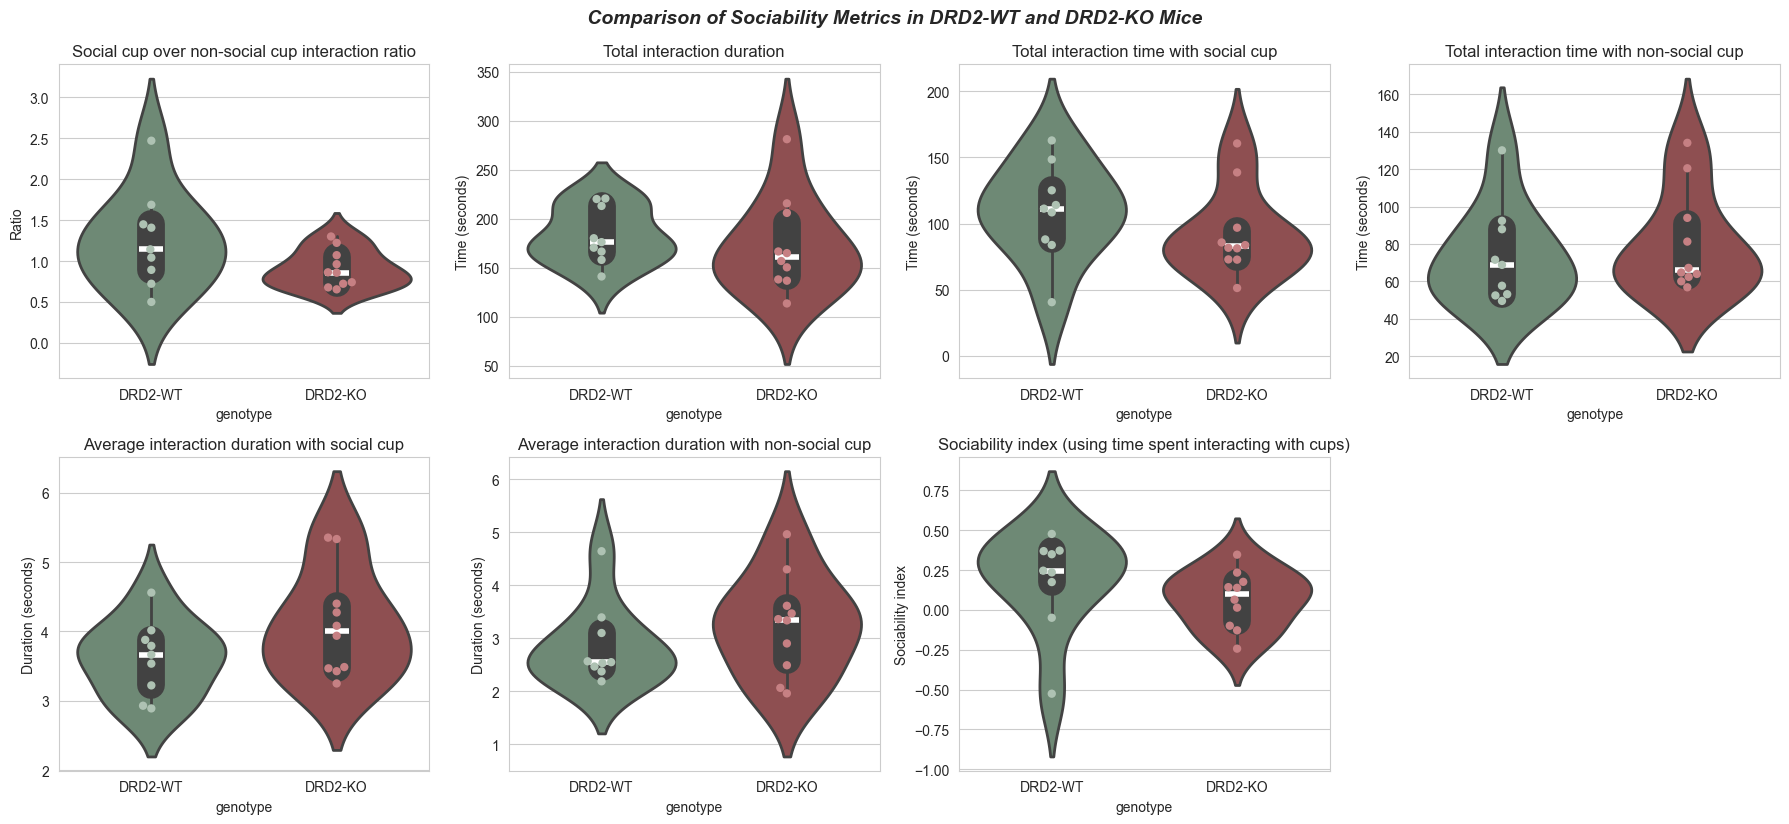

In [19]:
behaviour_stats = behaviour_stats.sort_values(by='genotype', ascending=False)
boxplot_cols = behaviour_stats.columns[2:]

swarmplot_palette = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}
violin_palette = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}

title_label_dict = {
    'interaction_ratio': ('Social cup over non-social cup interaction ratio', 'Ratio'),
    'total_interaction_time': ('Total interaction duration', 'Time (seconds)'),
    'total_social_interaction_duration': ('Total interaction time with social cup', 'Time (seconds)'),
    'total_non_social_interaction_duration': ('Total interaction time with non-social cup', 'Time (seconds)'),
    'average_social_cup_duration': ('Average interaction duration with social cup', 'Duration (seconds)'),
    'average_non_social_cup_duration': ('Average interaction duration with non-social cup', 'Duration (seconds)'),
    'sociability_index': ('Sociability index (using time spent interacting with cups)', 'Sociability index'),
}

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axs = axs.ravel()

for i, metric in enumerate(boxplot_cols):
    sns.violinplot(data=behaviour_stats, x='genotype', hue='genotype', y=metric, ax=axs[i], linewidth=2, inner_kws=dict(box_width=20, whis_width=2), palette=violin_palette)
    sns.swarmplot(data=behaviour_stats, x='genotype', hue='genotype', y=metric, ax=axs[i], color="white", edgecolor="auto", s=6, palette=swarmplot_palette)
    axs[i].set_title(title_label_dict[metric][0])
    axs[i].set_ylabel(title_label_dict[metric][1])
    
axs[-1].remove()
fig.tight_layout()
plt.suptitle('Comparison of Sociability Metrics in DRD2-WT and DRD2-KO Mice', fontsize=14, fontweight='bold', fontstyle='italic', y=1.025)
plt.show()

In [20]:
for i, metric in enumerate(boxplot_cols):
    print(f'\n{metric}')
    wt_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-WT'][metric]
    ko_metric_data = behaviour_stats[behaviour_stats.genotype == 'DRD2-KO'][metric]
    
    # perform independent t-test to compare means
    result = ttest_ind(wt_metric_data, ko_metric_data)

    print("T-statistic:", result.statistic)
    print("P-value:", result.pvalue)
    
    f_statistic, p_value = f_oneway(wt_metric_data, ko_metric_data)

    print("F-statistic:", f_statistic)
    print("P-value:", p_value)


interaction_ratio
T-statistic: 1.7463149424035729
P-value: 0.09879902599354357
F-statistic: 3.049615878061999
P-value: 0.09879902599354339

total_interaction_time
T-statistic: 0.5299882503007375
P-value: 0.602974156246012
F-statistic: 0.2808875454568361
P-value: 0.6029741562460129

total_social_interaction_duration
T-statistic: 1.0519740169982652
P-value: 0.3075357078311716
F-statistic: 1.1066493324394655
P-value: 0.30753570783117146

total_non_social_interaction_duration
T-statistic: -0.5519412170506541
P-value: 0.5881717538274838
F-statistic: 0.3046391070793584
P-value: 0.5881717538274835

average_social_cup_duration
T-statistic: -1.6095835454542815
P-value: 0.12589987023477503
F-statistic: 2.5907591897971773
P-value: 0.12589987023477506

average_non_social_cup_duration
T-statistic: -0.9535684122095398
P-value: 0.35366534532370486
F-statistic: 0.9092927167638222
P-value: 0.3536653453237047

sociability_index
T-statistic: 1.042554830503423
P-value: 0.31175464475797865
F-statistic: 1.

If there's any trend to be noticed, the KOs seem to be less social.